In [1]:
# init 
import glob
import numpy as np
import os, sys, re
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import listdir
from os.path import isfile, join
from skimage.transform import rescale, resize, downscale_local_mean,  warp, AffineTransform
from PIL import Image, ImageDraw, ImageFilter
from skimage import measure, img_as_ubyte, color 
from skimage.measure import ransac
import pandas as pd
import math 
from sklearn.metrics.pairwise import euclidean_distances
import cv2
from cellpose import utils, io, models, plot
from numpy import genfromtxt
import json

C:\Users\nyayon\Anaconda3\envs\cellpose\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\nyayon\Anaconda3\envs\cellpose\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\nyayon\Anaconda3\envs\cellpose\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
Image.MAX_IMAGE_PIXELS = 20000000000
os.chdir('H:\My Drive\Limb_visium\ActualData')
imgP1 = Image.open('spatial_0/tissue_hires_image_0.png')
img1 = np.array(imgP1)
imgP2 = Image.open('spatial_1/tissue_hires_image_1.png')
img2 = np.array(imgP2)
imgP3 = Image.open('spatial_2/tissue_hires_image_2.png')
img3 = np.array(imgP3)

<Figure size 1200x800 with 0 Axes>

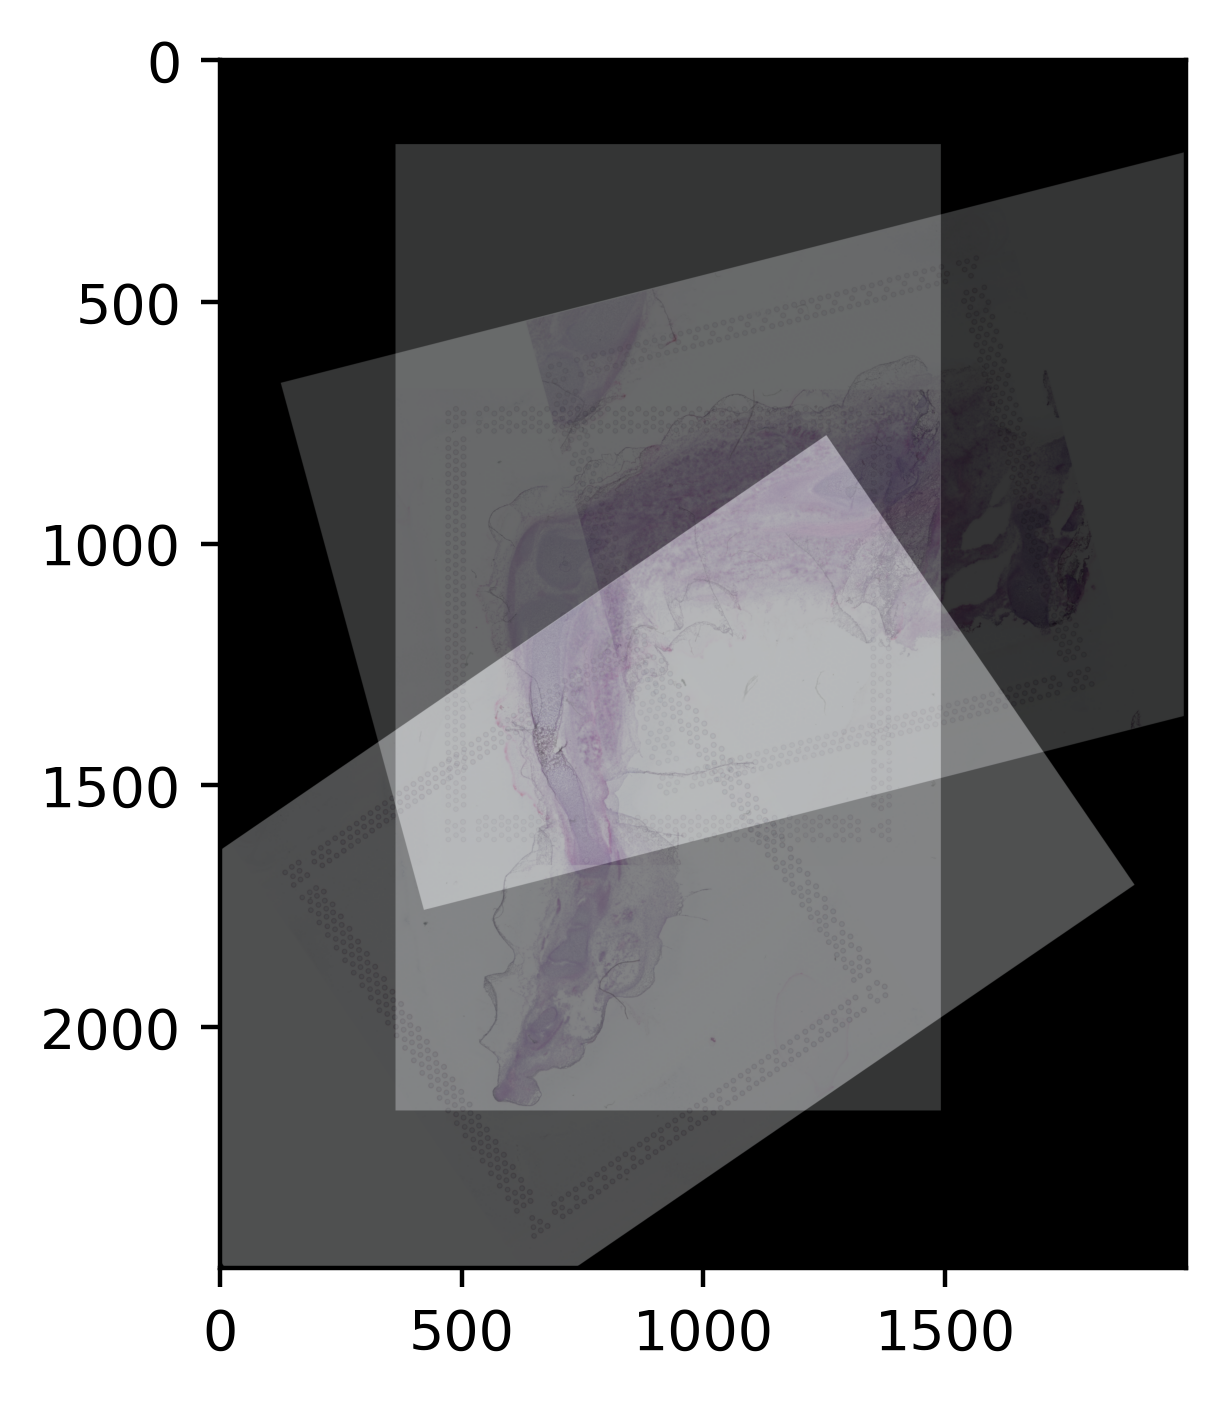

In [163]:
# these are a result from the TrackEM plugin in fiji and can be found in the project .xml file that is generated 
matrix1 = [[1.0,0.0],[0.0,1.0],[363.0,174.0]]
matrix2 = [[-0.2624898117336124,-0.9670515249339174],[0.9970949986936836,-0.2545807300700232],[421.616674241217,1757.8246406687272]]
matrix3 = [[0.5652114984004705,0.8249460358568282],[-0.8249460358568282,0.5652114984004705],[1253.4216002238893,776.4859181156044]]

M1 = np.asmatrix(np.array(matrix1)).T
M2 = np.asmatrix(np.array(matrix2)).T
M3 = np.asmatrix(np.array(matrix3)).T


dst1 = cv2.warpAffine(img1,M1,(2000,2500))
dst2 = cv2.warpAffine(img2,M2,(2000,2500))
dst3 = cv2.warpAffine(img3,M3,(2000,2500))
plt.figure(dpi=200)
# plt.imshow(dst1)
# plt.figure(dpi=200)
# plt.imshow(dst2)
# plt.figure(dpi=200)
# plt.imshow(dst3)


result = cv2.addWeighted(dst1, 0.33, dst2, 0.33, 0)
result2 = cv2.addWeighted(result, 0.66, dst3, 0.33, 0)
plt.figure(dpi=400)
plt.imshow(result2)
res1 = Image.fromarray(dst1)
res1.save('tissue_hires_image_0.png')
res2 = Image.fromarray(dst2)
res2.save('tissue_hires_image_1.png')
res3 = Image.fromarray(dst3)
res3.save('tissue_hires_image_2.png')
res = Image.fromarray(result2)
res.save('tissue_hires_image_all.png')


In [144]:
import json
spots1 = pd.read_csv('spatial_0/tissue_positions_list_0.csv',header=None)
f1 = open('spatial_0/scalefactors_json_0.json'); data1 = json.load(f1); scale1 = data1['tissue_hires_scalef'] 
spots2 = pd.read_csv('spatial_1/tissue_positions_list_1.csv',header=None)
f2 = open('spatial_1/scalefactors_json_1.json'); data2 = json.load(f2); scale2 = data2['tissue_hires_scalef'] 
spots3 = pd.read_csv('spatial_2/tissue_positions_list_2.csv',header=None)
f3 = open('spatial_2/scalefactors_json_2.json'); data3 = json.load(f3); scale3 = data3['tissue_hires_scalef'] 
spots1

0  1   2    3      4      5
0     ACGCCTGACACGCGCT-1  0   0    0  18350   2149
1     TACCGATCCAACACTT-1  0   1    1  18269   2289
2     ATTAAAGCGGACGAGC-1  0   0    2  18189   2149
3     GATAAGGGACGATTAG-1  0   1    3  18109   2289
4     GTGCAAATCACCAATA-1  0   0    4  18028   2149
...                  ... ..  ..  ...    ...    ...
4987  GAACGTTTGTATCCAC-1  1  77  123   8469  12904
4988  ATTGAATTCCCTGTAG-1  1  76  124   8389  12765
4989  TACCTCACCAATTGTA-1  1  77  125   8309  12904
4990  AGTCGAATTAGCGTAA-1  1  76  126   8228  12765
4991  TTGAAGTGCATCTACA-1  1  77  127   8148  12904

[4992 rows x 6 columns]

In [145]:
# transform grid to image space and plot ontop of original image
sp1 = np.asmatrix(np.vstack((np.array(spots1.iloc[:,5].values*scale1),np.array(spots1.iloc[:,4].values*scale1),np.ones(spots1.iloc[:,4].values.shape[0]))))
# sp1T = np.matrix.transpose(sp1)
M11 = np.append(M1, [[0,0,1]], axis = 0)
sp1TTarget = np.matmul(M11,sp1)
# transform grid to image space and plot ontop of original image
sp2 = np.asmatrix(np.vstack((np.array(spots2.iloc[:,5].values*scale2),np.array(spots2.iloc[:,4].values*scale2),np.ones(spots2.iloc[:,4].values.shape[0]))))
# sp1T = np.matrix.transpose(sp1)
M22 = np.append(M2, [[0,0,1]], axis = 0)
sp2TTarget = np.matmul(M22,sp2)
# transform grid to image space and plot ontop of original image
sp3 = np.asmatrix(np.vstack((np.array(spots3.iloc[:,5].values*scale3),np.array(spots3.iloc[:,4].values*scale3),np.ones(spots3.iloc[:,4].values.shape[0]))))
# sp1T = np.matrix.transpose(sp1)
M33 = np.append(M3, [[0,0,1]], axis = 0)
sp3TTarget = np.matmul(M33,sp3)

    

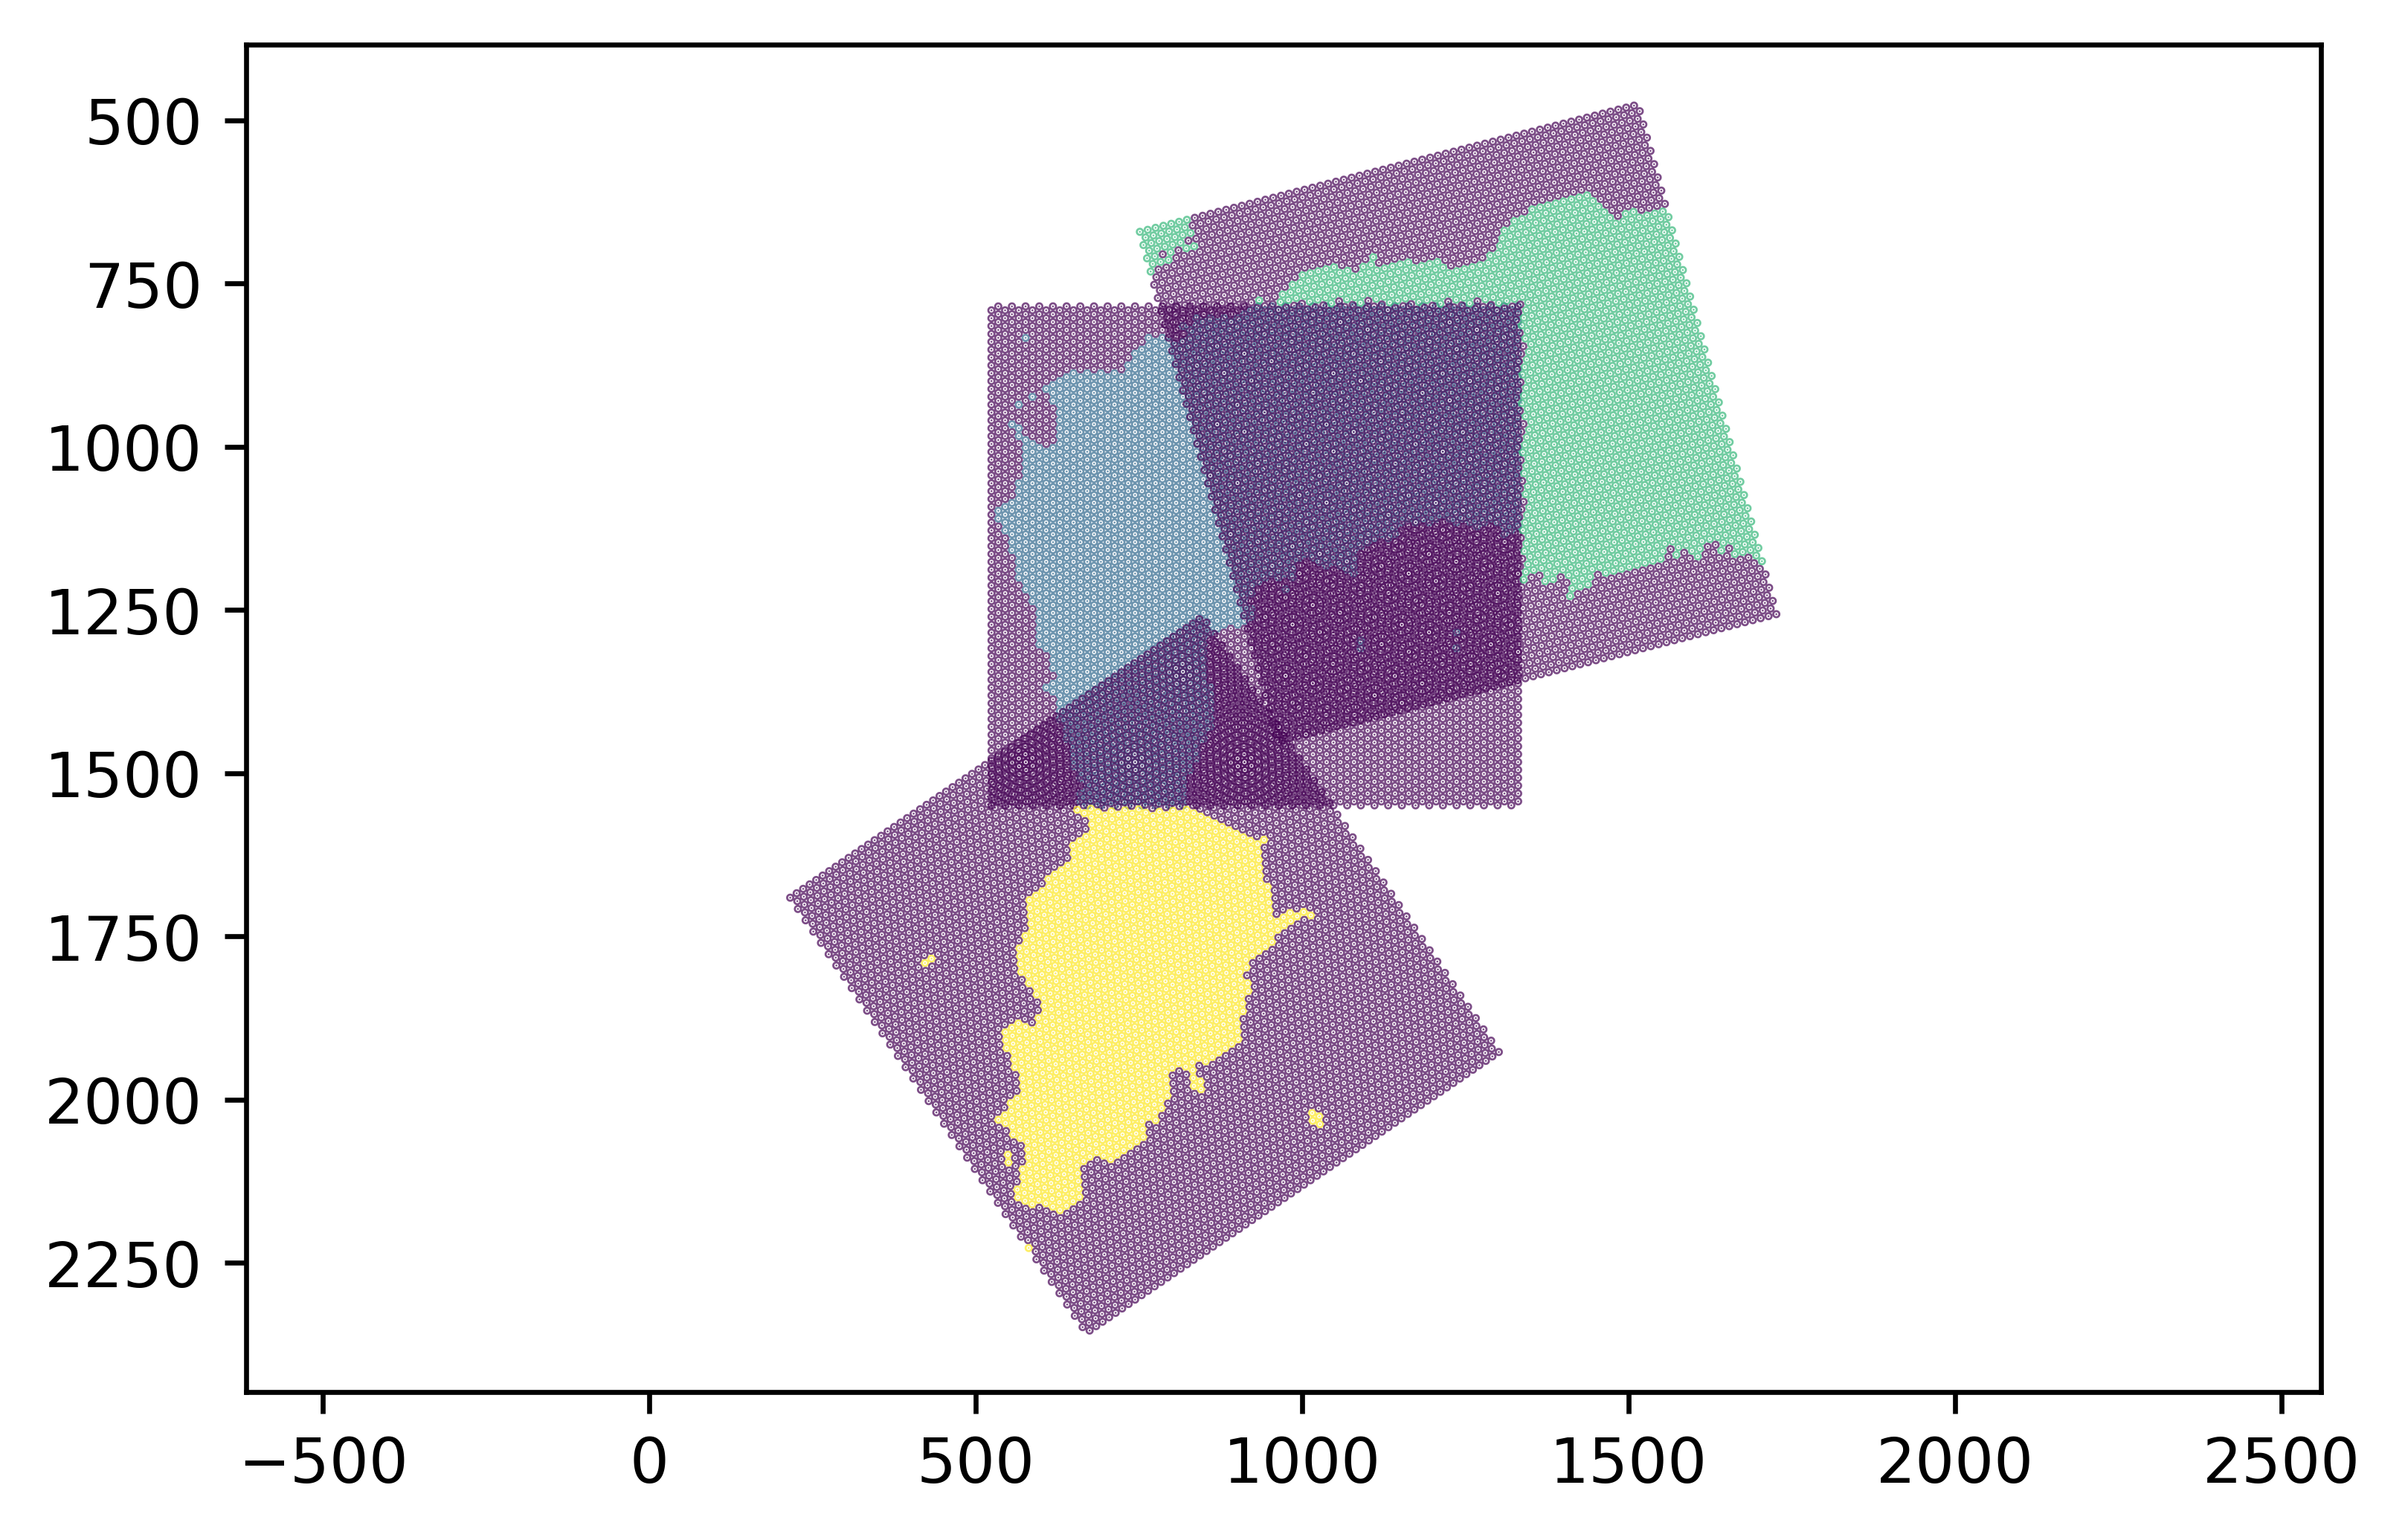

In [146]:
#correct overlap 
for p in range(sp1TTarget[0].size):
    dist = np.min(np.sum(np.abs(sp1TTarget[:-1,:]-sp3TTarget[:-1,p]),axis=0))
    # print(dist)
    if dist<10:
        spots3.iloc[p,1] = 0
        
for p in range(sp1TTarget[0].size):
    dist = np.min(np.sum(np.abs(sp1TTarget[:-1,:]-sp2TTarget[:-1,p]),axis=0))
    # print(dist)
    if dist<10:
        spots2.iloc[p,1] = 0
        
color = [(spots1.iloc[:,1].values).tolist(),(spots2.iloc[:,1].values*2).tolist(),(spots3.iloc[:,1].values*3).tolist()]
plt.figure(dpi=600)
plt.scatter([sp1TTarget[0,:].tolist(),sp2TTarget[0,:].tolist(),sp3TTarget[0,:].tolist()],[sp1TTarget[1,:].tolist(),sp2TTarget[1,:].tolist(),sp3TTarget[1,:].tolist()],s=0.1,c=color,alpha=0.7,facecolor=None)
plt.axis('equal')
plt.gca().invert_yaxis()

In [164]:
#correct barcodes
spots11 = spots1.copy()
# spots11.iloc[:,0] =  'a-' + spots11.iloc[:,0]
spots22 = spots2.copy()
# spots22.iloc[:,0] =  'b-' + spots22.iloc[:,0]
spots33 = spots3.copy()
# spots33.iloc[:,0] =  'c-' + spots33.iloc[:,0]
spots33


0  1   2    3      4      5
0     ACGCCTGACACGCGCT-1  0   0    0  18314   2237
1     TACCGATCCAACACTT-1  0   1    1  18234   2377
2     ATTAAAGCGGACGAGC-1  0   0    2  18153   2237
3     GATAAGGGACGATTAG-1  0   1    3  18073   2377
4     GTGCAAATCACCAATA-1  0   0    4  17993   2238
...                  ... ..  ..  ...    ...    ...
4987  GAACGTTTGTATCCAC-1  0  77  123   8473  13021
4988  ATTGAATTCCCTGTAG-1  0  76  124   8392  12881
4989  TACCTCACCAATTGTA-1  0  77  125   8312  13021
4990  AGTCGAATTAGCGTAA-1  0  76  126   8232  12882
4991  TTGAAGTGCATCTACA-1  0  77  127   8152  13022

[4992 rows x 6 columns]

In [165]:
# ocrrect coordinates
spots11.iloc[:,-2:] =  (sp1TTarget[:-1,:].T*(1/scale1)).tolist()
spots22.iloc[:,-2:] =  (sp2TTarget[:-1,:].T*(1/scale2)).tolist()
spots33.iloc[:,-2:] =  (sp3TTarget[:-1,:].T*(1/scale3)).tolist()
spots33

0  1   2    3             4             5
0     ACGCCTGACACGCGCT-1  0   0    0   2876.960287  22555.009638
1     TACCGATCCAACACTT-1  0   1    1   3022.085580  22625.285163
2     ATTAAAGCGGACGAGC-1  0   0    2   3009.776599  22464.010586
3     GATAAGGGACGATTAG-1  0   1    3   3154.901892  22534.286111
4     GTGCAAATCACCAATA-1  0   0    4   3142.333176  22374.401693
...                  ... ..  ..  ...           ...           ...
4987  GAACGTTTGTATCCAC-1  0  77  123  17090.495025  25888.981332
4988  ATTGAATTCCCTGTAG-1  0  76  124  17078.186044  25727.706756
4989  TACCTCACCAATTGTA-1  0  77  125  17223.311337  25797.982281
4990  AGTCGAATTAGCGTAA-1  0  76  126  17210.742621  25638.097862
4991  TTGAAGTGCATCTACA-1  0  77  127  17355.867914  25708.373388

[4992 rows x 6 columns]

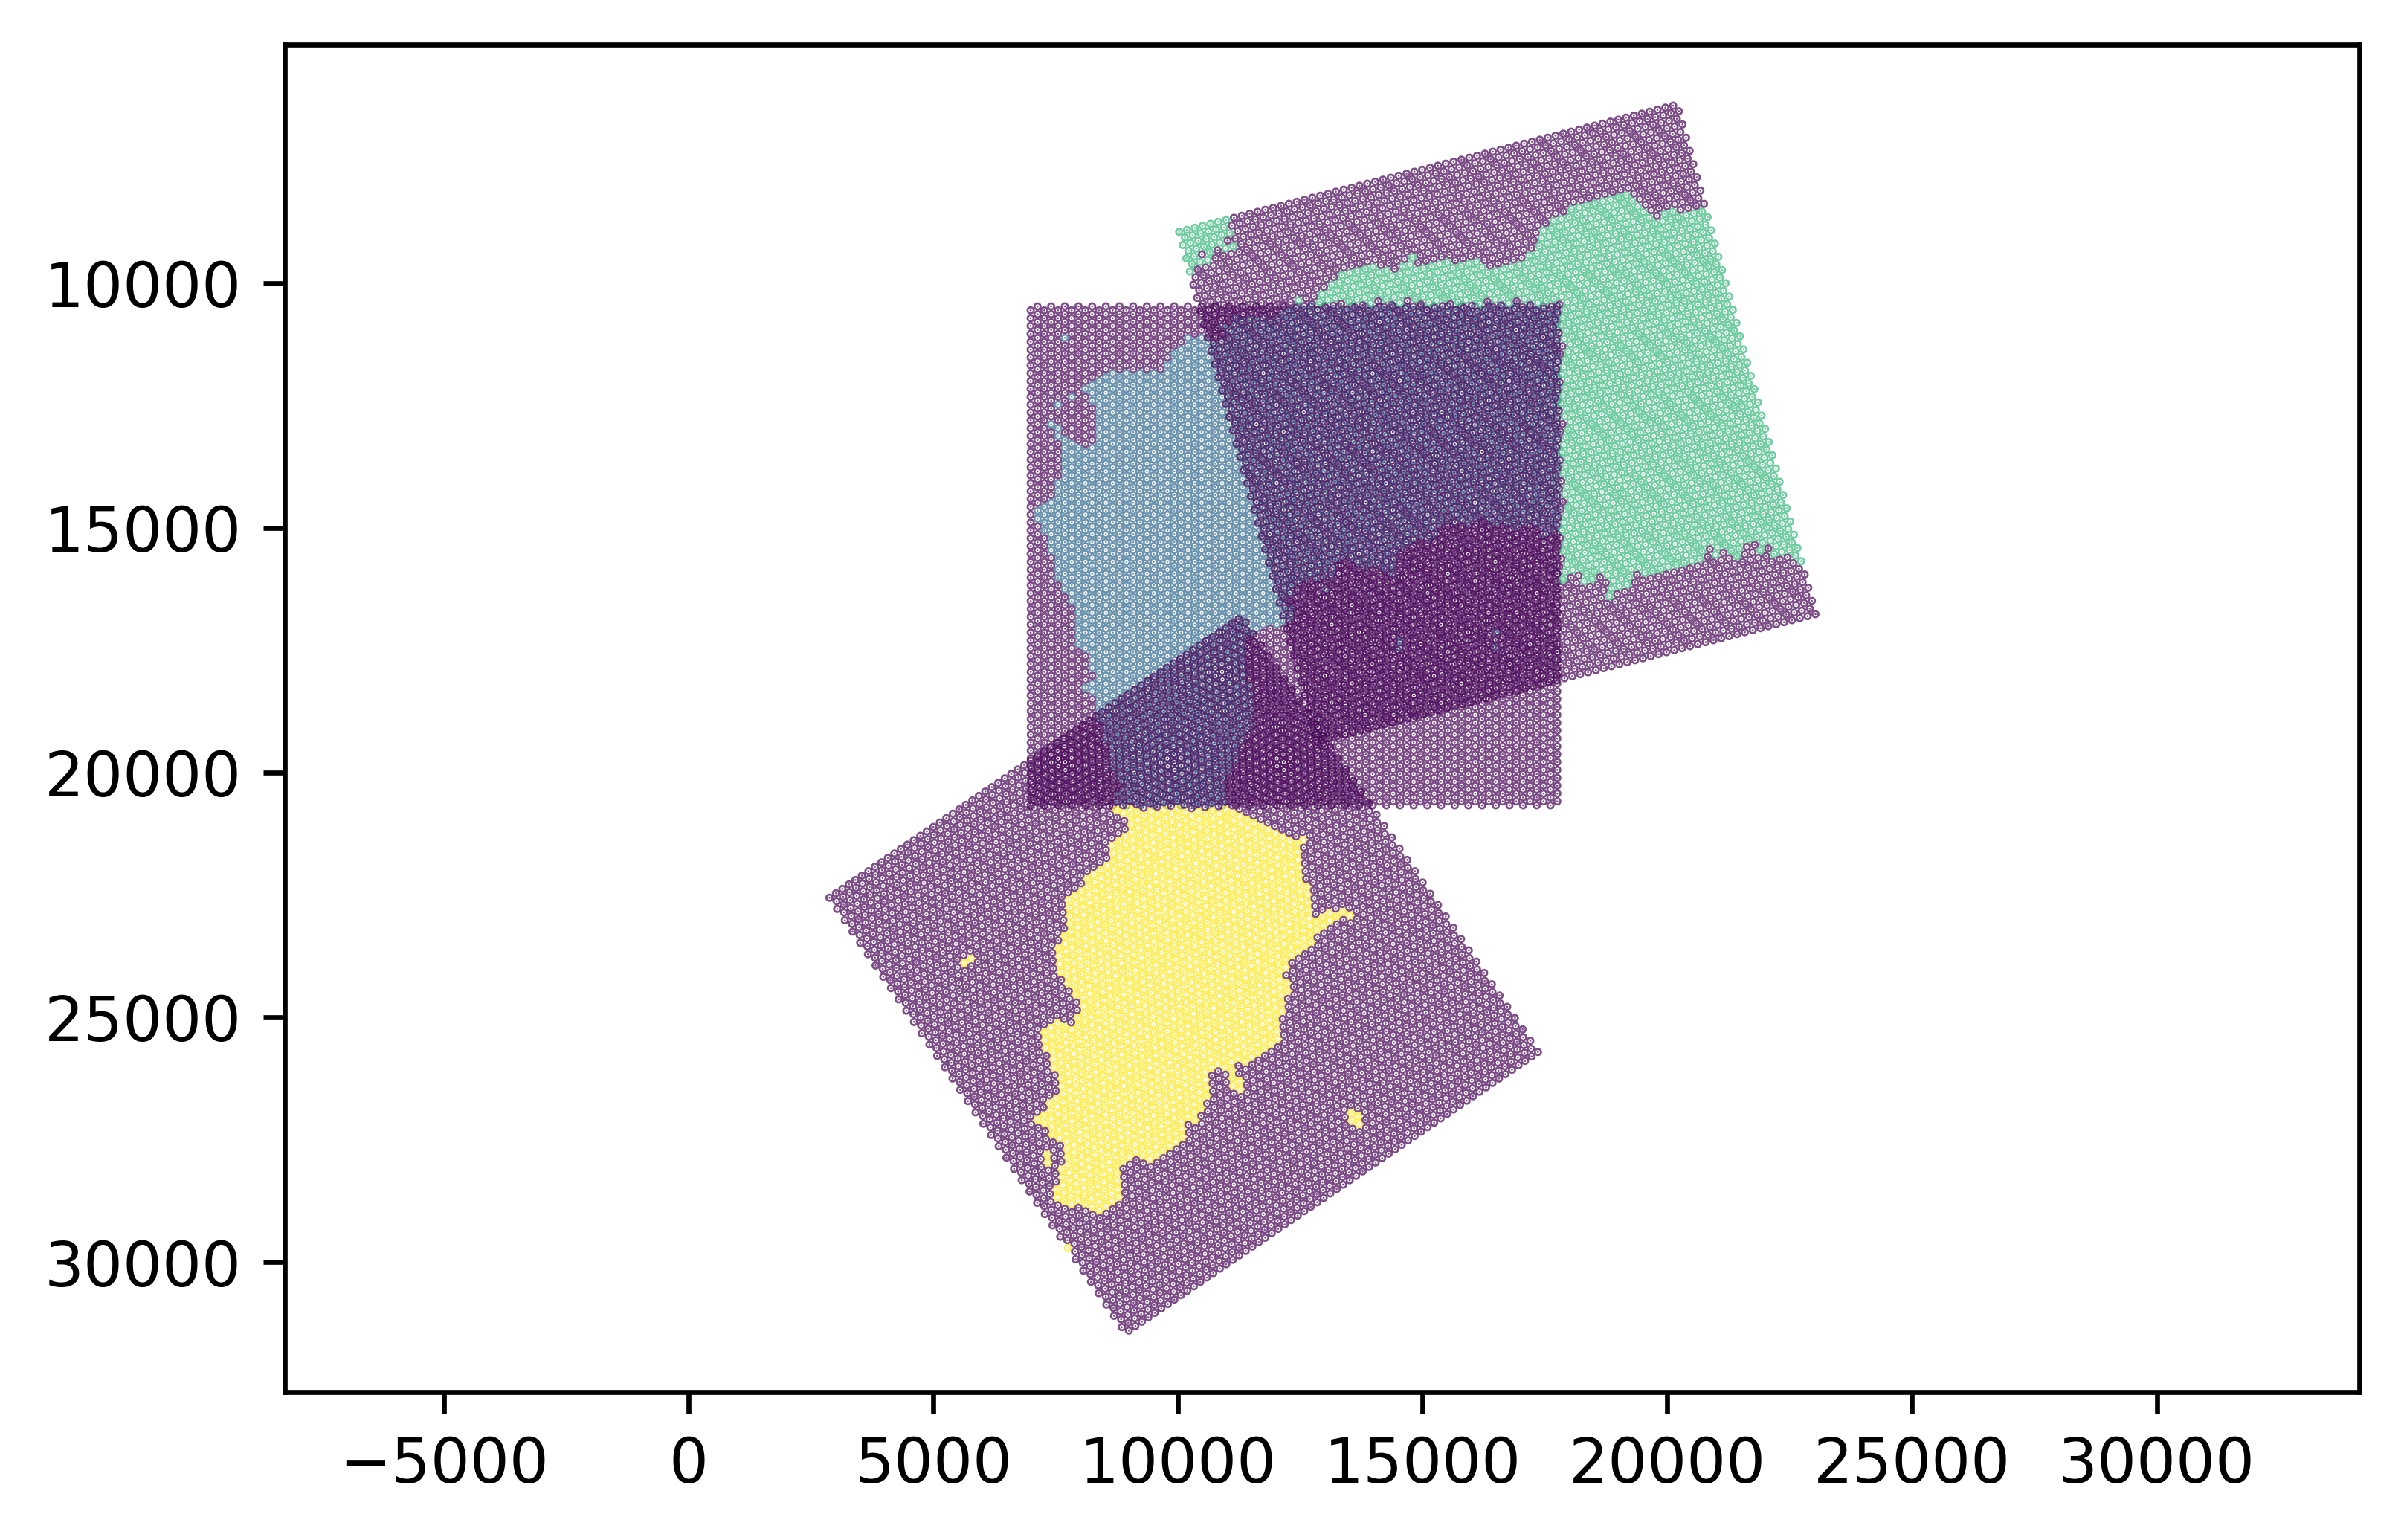

In [166]:
#make sure everything is ok 
color = [(spots11.iloc[:,1].values).tolist(),(spots22.iloc[:,1].values*2).tolist(),(spots33.iloc[:,1].values*3).tolist()]
plt.figure(dpi=600)
plt.scatter([spots11.iloc[:,4].values.tolist(),spots22.iloc[:,4].values.tolist(),spots33.iloc[:,4].values.tolist()],[spots11.iloc[:,5].values.tolist(),spots22.iloc[:,5].values.tolist(),spots33.iloc[:,5].values.tolist()],s=0.1,c=color,alpha=0.7,facecolor=None)
plt.axis('equal')
plt.gca().invert_yaxis()

In [172]:
spots11.to_csv('spatial_0/tissue_positions_list_0.csv',header=False,index=False)
spots22.to_csv('spatial_1/tissue_positions_list_0.csv',header=False,index=False)
spots33.to_csv('spatial_2/tissue_positions_list_0.csv',header=False,index=False)

#